<a href="https://colab.research.google.com/github/PeiYauWeng/MODQPSO_training_FNN/blob/main/MOQDPSO_training_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

class Mesh_Swarm(object):
  def __init__(self, num_particles, current_archiving_locations, current_archiving_fitness, num_mesh, maximum, minimum):
    self.current_archiving_locations = current_archiving_locations
    self.current_archiving_fitness = current_archiving_fitness
    self.num_mesh = num_mesh
    self.minimum = minimum
    self.maximum = maximum
    self.num_archiving_particles = self.current_archiving_locations.shape[0]
    self.num_particles = num_particles
    
    self.id_archiving_particles = np.zeros((self.num_archiving_particles))
    self.gbest_parameters = np.zeros((self.num_particles, self.current_archiving_locations.shape[1]))
    self.gbest_fitness = np.zeros((self.num_particles, self.current_archiving_fitness.shape[1]))

  def get_crowd_archiving_particles(self):
    tmp = np.multiply(self.num_mesh, np.subtract(self.current_archiving_locations, self.minimum)) 
    distance = np.subtract(self.maximum, self.minimum)
    self.id_archiving_particles = np.divide(tmp, distance).astype(np.int32)
    judge_table = self.id_archiving_particles[:,np.newaxis,:] == self.id_archiving_particles
    judge_table = (np.sum(judge_table, axis=2)==self.id_archiving_particles.shape[1])
    crowd_archiving_particles = np.sum(judge_table, axis=1)
    return crowd_archiving_particles

  def get_gbest(self):
    crowd_archiving_particles = self.get_crowd_archiving_particles()
    get_probability_chosen = np.divide(1.0,(np.power(crowd_archiving_particles,3)))
    get_probability_chosen = get_probability_chosen/np.sum(get_probability_chosen)
    chosen_index = np.multiply(get_probability_chosen, np.random.uniform(0,1, (self.num_mesh,self.num_archiving_particles)))
    chosen_index = np.sum(chosen_index, axis=0)
    chosen_index = np.argsort(chosen_index)[np.int32(self.num_archiving_particles*0.9)-1:]
    chosen_index = np.random.choice(chosen_index,size=(self.num_particles),replace=True)
    self.gbest_parameters = self.current_archiving_locations[chosen_index]
    self.gbest_fitness = self.current_archiving_fitness[chosen_index]
    return self.gbest_parameters, self.gbest_fitness

  def pair_inner_outer_gbest(self):
    pair_table=np.sum(np.power(np.subtract(self.gbest_parameters, self.gbest_parameters[:,np.newaxis,:]), 2), axis=2)
    pair_table=np.argmax(pair_table, axis=1)
    outer_gbest_parameters = self.gbest_parameters[pair_table]
    return outer_gbest_parameters
    
  def clear_archives(self,threshold):
    crowd_archiving_particles = self.get_crowd_archiving_particles()
    get_probability_chosen = crowd_archiving_particles/np.sum(crowd_archiving_particles)
    clear_index = np.multiply(get_probability_chosen, np.random.uniform(0,1, (self.num_mesh,self.num_archiving_particles)))
    clear_index = np.sum(clear_index, axis=0)
    clear_index = np.argsort(clear_index)[threshold:]
    self.current_archiving_locations = np.delete(self.current_archiving_locations, clear_index, axis=0)
    self.current_archiving_fitness = np.delete(self.current_archiving_fitness, clear_index, axis=0)
    return self.current_archiving_locations, self.current_archiving_fitness


In [ ]:
class Pareto(object):
  def __init__(self, locations, fitness):
    self.locations = locations
    self.fitness = fitness
    self.dominant_value = len(self.fitness)-1
  
  def find_optimals(self):
    judge_table = self.fitness[:,np.newaxis,:] < self.fitness
    delete_index = np.sign(np.sum(judge_table, axis=2))
    delete_index = np.sum(delete_index, axis=1)
    self.fitness = np.delete(self.fitness, np.argwhere(delete_index<self.dominant_value), axis=0)
    self.locations = np.delete(self.locations, np.argwhere(delete_index<self.dominant_value), axis=0)
    return self.locations, self.fitness

In [ ]:

class MOQDPSO(object):
  '''num_particle: the number of particles
     dim_paricel: the dimesion of particles that correspond to the number of unoptimized parameters
     alpha: type of float. It is the contraction expansion coefficient and a positive number
     iterations: the number of iterstions
     maximum: type of float
     minimum: type of float'''
  def __init__(self, num_particles, dim_per_particle, num_objects, iterations, num_mesh, maximum, minimum, threshold, dtype):
    #define class parameters
    self.num_particles = num_particles
    self.dim_per_particle = dim_per_particle
    self.alpha = 1.0
    self.iterations = iterations
    self.maximum = maximum
    self.minimum = minimum
    self.num_mesh = num_mesh
    self.threshold = threshold
    self.dtype = dtype
    #initialize positions of swarm particles
    '''self.locations = np.array(np.random.uniform(self.minimum, 
                           self.maximum, 
                           size=(self.num_particles, self.dim_per_particle)),
                           dtype=self.dtype)'''
    self.locations = np.empty(shape=(self.num_particles, self.dim_per_particle), dtype=self.dtype)
    self.pbest_parameters = np.zeros(shape=(self.num_particles, self.dim_per_particle), dtype=self.dtype)
    self.fitness_values = np.multiply(np.inf, np.ones(shape=(self.num_particles, num_objects), dtype=self.dtype))
    self.archiving_locations = self.locations
    self.archiving_fitness = np.multiply(np.inf, np.ones(shape=(self.num_particles, num_objects), dtype=self.dtype))
    self.gbest_parameters = np.zeros(shape=(self.num_particles, self.dim_per_particle), dtype=self.dtype)
    self.outer_gbest_pair = np.zeros(shape=(self.num_particles, self.dim_per_particle), dtype=self.dtype)

  '''QPSO initialize the first array of parameters.
     let users put in their model to run'''
  def get_particle_locations(self):
    return self.locations

  def input_new_locations(self, new_locations):
    self.locations = new_locations

  '''Co-learning method'''
  def co_learning_method(self, learning_rate):
    judge_table = np.random.rand(self.num_particles,1)>learning_rate
    invert_table = np.invert(judge_table)
    random_index = np.random.choice(np.arange(0,self.num_particles,1),size=(self.num_particles), replace=True)
    self_pair_table = (random_index==np.arange(0,self.num_particles,1))
    random_index = np.add(np.multiply(random_index, np.invert(self_pair_table)), 
                np.int32(np.multiply(np.multiply(random_index,self_pair_table),np.random.rand(self.num_particles))))
    random_index[0] = np.add(np.multiply(self_pair_table[0], np.random.choice(np.arange(0,self.num_particles,1))),
                 np.multiply(np.invert(self_pair_table[0]), random_index[0]))
    dis_pbest2locations = np.add(np.multiply(np.subtract(self.locations, self.pbest_parameters),judge_table),
                   np.multiply(np.subtract(self.locations, self.pbest_parameters[random_index]), invert_table))
    dis_pbest2locations = np.abs(dis_pbest2locations)
    return self.dtype(dis_pbest2locations)

  '''calculate fittness value
     input: self class object
           locations: the list of particles locations
           validation_scores: the 2D np array of validation score from the model
     output: fitness_value: the list of fitness_vlaue'''
  def fitness(self, validation_scores):
    #2D array validation scores
    current_fitness_values = np.array(validation_scores, dtype=self.dtype)

    '''get current pbest parameters, archiving locations, archiving firness, gbest parameters and best fittness'''
    #update pbest_parameters and fitness_values(pbest fitness)
    judge_table = np.sign(np.subtract(current_fitness_values, self.fitness_values))
    t1=np.where(np.sum((judge_table == 1)+(judge_table == 0), axis=1)==3)
    t2=np.where(np.sum((judge_table == -1)+(judge_table == 0), axis=1)==3)
    random_index = np.arange(0,self.num_particles,1)
    random_index = np.delete(random_index, np.hstack([np.array(t1),np.array(t2)]).flatten(), axis=0)
    #random_index = np.arange(0,self.num_particles,1)
    if random_index.shape[0]>0:
      random_index = np.random.choice(random_index, random_index.shape[0]//2, replace=False)
      self.fitness_values[random_index] = current_fitness_values[random_index]
      self.pbest_parameters[random_index] = self.locations[random_index]
    self.fitness_values[t2] = current_fitness_values[t2]
    self.pbest_parameters[t2] = self.locations[t2]
  
    #update archiving locations and archiving fitness
    
    pareto = Pareto(self.locations, current_fitness_values)
    optimal_locations, optimal_fitness = pareto.find_optimals()
    self.archiving_locations = np.concatenate((self.archiving_locations, optimal_locations), axis=0)
    self.archiving_fitness = np.concatenate((self.archiving_fitness, optimal_fitness), axis=0)
    pareto = Pareto(self.archiving_locations, self.archiving_fitness)
    self.archiving_locations, self.archiving_fitness = pareto.find_optimals()
    archiving = Mesh_Swarm(self.num_particles, self.archiving_locations, self.archiving_fitness, 
                 self.num_mesh, self.maximum, self.minimum)
    self.archiving_locations, self.archiving_fitness = archiving.clear_archives(self.threshold)

    #update gbest parameters
    archiving = Mesh_Swarm(self.num_particles, self.archiving_locations, self.archiving_fitness, 
                 self.num_mesh, self.maximum, self.minimum)
    self.gbest_parameters, gbest_fitness = archiving.get_gbest()
    self.outer_gbest_pair = archiving.pair_inner_outer_gbest()
    #a[np.argmax(np.mean(a, axis=1))]              
    #return np.min(gbest_fitness, axis=0)
    return gbest_fitness[np.argmin(np.mean(gbest_fitness, axis=1))]

  '''update particle positions
     input: self class object
     locations: the list of particles locations
     gbest_parameters: the list of global best parameters
     pbest_parameters: the list of the best position ever for every particle
     output: locations: the new list of particle positions'''
  def update(self, num_iteration):
    #calculate the distance between particle locations and mbest
    co_learning_rate = np.power(np.subtract(1, np.power((num_iteration/self.iterations), 1/2)), 2)
    dis_co_pbest2locations = self.co_learning_method(co_learning_rate)

    #update random_point
    a = np.array(np.random.uniform(0, 1, size=(self.num_particles,1)),dtype=self.dtype)#covergence coefficient
    P1_pbest_parameters = np.multiply(a, self.pbest_parameters)
    tmp = np.multiply(np.subtract(1,a), self.gbest_parameters)
    P1_pbest_parameters = np.add(P1_pbest_parameters, tmp)
    a = np.array(np.random.uniform(0, 1, size=(self.num_particles,1)),dtype=self.dtype)#covergence coefficient
    P2_pbest_parameters = np.multiply(a, self.pbest_parameters)
    tmp = np.multiply(np.subtract(1,a), self.outer_gbest_pair)
    P2_pbest_parameters = np.add(P2_pbest_parameters, tmp)

    #update double contract expand coefficient: alpha, beta
    self.alpha = self.dtype(0.5*(self.iterations-num_iteration)/self.iterations + 0.5)
    tmp = np.sign(np.subtract(np.random.uniform(0,1,size=(self.num_particles,1)), 0.5))
    self.alpha = np.multiply(self.alpha, tmp)

    #update particle locations
    ln_one2u = np.log(np.divide(1, np.random.uniform(size=(self.num_particles, 1))))
    tmp = np.multiply(self.alpha, np.multiply(ln_one2u, dis_co_pbest2locations))
    beta = np.random.rand(self.num_particles, 1)
    self.locations = np.multiply(1/2, np.add(np.add(P1_pbest_parameters, P2_pbest_parameters), 
                          np.multiply(beta, np.subtract(P1_pbest_parameters,P2_pbest_parameters))))
    #self.locations = np.add(tmp_pbest_parameters,tmp)
    #the paticle locations must be in [minimum, maximum] after updating
    tmp = np.divide(np.subtract(self.locations,np.min(self.locations, axis=0)), 
                   np.ptp(self.locations, axis=0))
    self.locations = np.add(np.multiply(tmp,(self.maximum-self.minimum)), self.minimum)

In [ ]:
class Node_deletion_rule(object):
  def __init__(self, model_shape, num_particle, locations):
    self.model_shape = np.array(model_shape)
    self.num_layers = len(model_shape) - 1
    self.num_particle = num_particle
    self.locations = locations
    self.num_connection = np.matmul(self.model_shape[np.newaxis,:-1], self.model_shape[np.newaxis,1:].T)[0,0]
    self.num_hidden_neurons = np.sum(model_shape[1:-1])
    self.smallest_bias = 0

  def trans_NN_weight(self, a_particle):
    flag=0
    record_layer_bias = list()
    record_layer_weight = list()
    total_bias = np.empty(0)
    for i in range(self.num_layers):
      layer_num_weight = self.model_shape[i]*self.model_shape[i+1]
      layer_num_bias = 1*self.model_shape[i+1]
      layer_weight = np.reshape(a_particle[flag:flag+layer_num_weight+layer_num_bias], newshape=(self.model_shape[i]+1,self.model_shape[i+1]))
      layer_bias, layer_weight = layer_weight[0], layer_weight[1:]
      total_bias = np.hstack((total_bias, layer_bias))
      record_layer_bias.append(layer_bias)
      record_layer_weight.append(layer_weight)
      flag += layer_num_weight+layer_num_bias
    self.smallest_bias = np.min(np.abs(total_bias))
    return record_layer_bias, record_layer_weight

  def rebuild_layer_weights(self, front_layer_weights, back_layer_weights):
    judge_table = self.smallest_bias <= np.abs(front_layer_weights)
    judge_table = np.sign(judge_table.sum(axis=0))
    judge_table2 = self.smallest_bias <= np.abs(back_layer_weights)
    judge_table2 = np.sign(judge_table2.sum(axis=1))
    judge_table = np.multiply(judge_table2, judge_table)
    deleted_neurons = np.sum(judge_table==0)
    front_layer_weights = np.multiply(front_layer_weights, judge_table)
    back_layer_weights = np.multiply(back_layer_weights, judge_table[:,np.newaxis])
    return front_layer_weights, back_layer_weights, deleted_neurons

  def execute_rule(self):
    ratio_active_connections = list()
    ratio_active_nodes = list()
    for i in range(self.num_particle):
      tmp_location = np.empty(0)
      total_deleted_neurons = 0
      num_inactive_connection = 0
      layers_bias, layers_weight = self.trans_NN_weight(self.locations[i])
      for j in range(self.num_layers-1):
        layers_weight[j], layers_weight[j+1], deleted_neurons = self.rebuild_layer_weights(layers_weight[j], layers_weight[j+1])
        total_deleted_neurons += deleted_neurons
      for k in range(self.num_layers):
        num_inactive_connection += np.sum(layers_weight[k]==0.0)
        tmp_location = np.hstack((tmp_location, np.hstack((layers_bias[k] , layers_weight[k].flatten('C')))))
      self.locations[i] = tmp_location
      ratio_active_connections.append((self.num_connection - num_inactive_connection)/self.num_connection)
      ratio_active_nodes.append((self.num_hidden_neurons - total_deleted_neurons)/self.num_hidden_neurons)
    return self.locations, np.array(ratio_active_connections), np.array(ratio_active_nodes)

In [ ]:
import matplotlib.pyplot as plt

def plot(results):
  # draw a diagram
  x = []
  y = []
  for i in range(len(results)):
    x.append(i + 1)
    y.append(results[i])
  plt.plot(x,y)
  plt.xlabel('Number of iteration',size = 15)
  plt.ylabel('Value of CV',size = 15)
  plt.title('QDPSO_RBF_SVM parameter optimization')
  plt.show() 

In [ ]:
from sklearn.datasets import load_iris

data = load_iris()
x = data.data
y = data.target

In [ ]:
n_inputs = 4
n_hidden = 20
n_classes = 3
model_shape = [4, 20 ,3]

num_samples = 150

def logits_function(x, layers_bias, layers_weight):
  z1 = x.dot(layers_weight[0])+layers_bias[0]
  a1 = np.tanh(z1)
  logits = a1.dot(layers_weight[1])+layers_bias[1]
  return logits

def evaluation(y, logits, num_samples, ratio_active_connection, ratio_active_node):
  exp_scores = np.exp(logits)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
  logprobs = -np.log(probs[range(num_samples), y])
  loss = np.sum(logprobs) / num_samples
  y_result = np.argmax(logits, axis=1)
  error = 1.0 - (y_result==y).mean()
  #print((y_result==y).mean())
  #MDL = error + ratio_active_connection
  fitting_value = np.power(ratio_active_connection,0.5)*np.power(ratio_active_node, 2)
  return [loss, error, fitting_value]

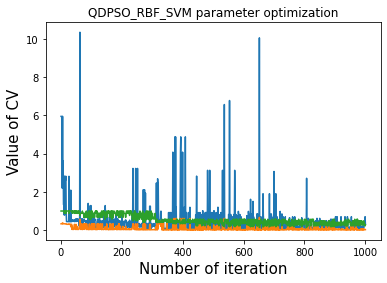

Training time:  22.663706302642822  seconds


In [ ]:
import time
n_inputs = 4
n_hidden = 20
n_classes = 3
model_shape = [4, 20 ,3]
num_samples = 150
num_particles = 50
dim_per_particle = (n_inputs * n_hidden) + (n_hidden * n_classes) + n_hidden + n_classes 
num_ojects = 3
iterations = 1000
num_mesh = 10
threshold = 150
maximum = 30.0
minimum = -15.0
evaluation_threshold = [0.1, 0.02, 0.7]
storage=list()
#num_particles, dim_per_particle, num_objects, iterations, num_mesh, maximum, minimum, threshold, dtype)
particle_locations = np.array(np.random.uniform(minimum, 
                           maximum, 
                           size=(num_particles, dim_per_particle)),
                           dtype=np.float32)
moqdpso = MOQDPSO(num_particles, dim_per_particle, num_ojects, iterations, num_mesh, maximum, minimum, threshold, np.float32)
moqdpso.input_new_locations(particle_locations)
best_fitness_history=[]
evaluation_threshold = np.array(evaluation_threshold)
start_time = time.time()
for i in range(iterations):
  score_storage=[]
  particle_locations = moqdpso.get_particle_locations()
  deletion = Node_deletion_rule(model_shape, num_particles, particle_locations)
  particle_locations, ratio_active_connections, ratio_active_nodes = deletion.execute_rule()
  moqdpso.input_new_locations(particle_locations)
  for j in range(num_particles):
    layer_bias, layer_weight = deletion.trans_NN_weight(particle_locations[j])
    model = logits_function(x, layer_bias, layer_weight)
    evaluation_val = evaluation(y, model, num_samples, ratio_active_connections[j], ratio_active_nodes[j])
    if (np.sum(evaluation_val<=evaluation_threshold)==3):
      storage.append([evaluation_val, layer_bias, layer_weight])
    score_storage.append(evaluation_val)
  #print(score_storage)
  best_fitness = moqdpso.fitness(score_storage)
  #print(best_fitness)
  best_fitness_history.append(best_fitness)
  moqdpso.update(i+1)
end_time = time.time()

plot(best_fitness_history)
print('Training time: ',(end_time-start_time),' seconds')

In [ ]:
best_fitness_history[650:680]

[array([0.06864525, 0.02      , 0.2788548 ], dtype=float32),
 array([0.06864525, 0.02      , 0.2788548 ], dtype=float32),
 array([0.06864525, 0.02      , 0.2788548 ], dtype=float32),
 array([0.06864525, 0.02      , 0.2788548 ], dtype=float32),
 array([0.0549007 , 0.02      , 0.34063038], dtype=float32),
 array([0.22742638, 0.01333333, 0.5724334 ], dtype=float32),
 array([0.06864525, 0.02      , 0.2788548 ], dtype=float32),
 array([0.22742638, 0.01333333, 0.5724334 ], dtype=float32),
 array([0.22742638, 0.01333333, 0.5724334 ], dtype=float32),
 array([0.06864525, 0.02      , 0.2788548 ], dtype=float32),
 array([0.22742638, 0.01333333, 0.5724334 ], dtype=float32),
 array([0.0549007 , 0.02      , 0.34063038], dtype=float32),
 array([0.22742638, 0.01333333, 0.5724334 ], dtype=float32),
 array([0.06864525, 0.02      , 0.2788548 ], dtype=float32),
 array([0.0549007 , 0.02      , 0.34063038], dtype=float32),
 array([0.0549007 , 0.02      , 0.34063038], dtype=float32),
 array([0.0549007 , 0.02

In [ ]:
best_fitness_history[900:]

[array([0.2111179 , 0.01333333, 0.4099634 ], dtype=float32),
 array([0.7033484, 0.02     , 0.22434  ], dtype=float32),
 array([0.12690446, 0.02      , 0.4099634 ], dtype=float32),
 array([0.19861367, 0.07333333, 0.2788548 ], dtype=float32),
 array([0.19861367, 0.07333333, 0.2788548 ], dtype=float32),
 array([0.29376185, 0.04      , 0.34063038], dtype=float32),
 array([0.7033484, 0.02     , 0.22434  ], dtype=float32),
 array([0.12690446, 0.02      , 0.4099634 ], dtype=float32),
 array([0.3038155 , 0.02666667, 0.2788548 ], dtype=float32),
 array([0.12690446, 0.02      , 0.4099634 ], dtype=float32),
 array([0.19861367, 0.07333333, 0.2788548 ], dtype=float32),
 array([0.12690446, 0.02      , 0.4099634 ], dtype=float32),
 array([0.19861367, 0.07333333, 0.2788548 ], dtype=float32),
 array([0.19861367, 0.07333333, 0.2788548 ], dtype=float32),
 array([0.3038155 , 0.02666667, 0.2788548 ], dtype=float32),
 array([0.12690446, 0.02      , 0.4099634 ], dtype=float32),
 array([0.12690446, 0.02      

In [ ]:
storage

[[[0.05538374890646886, 0.013333333333333308, 0.5724334022399462],
  [array([ 11.37048465, -12.2958024 ,  18.40505271, -14.11968169,
            9.57873432,  19.77480059,  -8.80054326,  26.69739038,
           11.28623283,  17.14261851,  -9.66159387,  -8.58907226,
           26.62179669, -13.06452014,   9.78183271, -14.17117891,
          -12.36825679, -13.31453841,   6.42736533,  24.82048958]),
   array([26.60283105, 16.61890401, 27.69845132])],
  [array([[  0.        , -11.56054124, -14.30199267,  19.72837625,
            -2.78580088,  16.34863029,  -0.        ,  -8.2068128 ,
            13.34272516,  -0.        ,  28.41949186,  20.16692521,
            16.27304432,  -9.4245809 ,   6.90558625,  -0.        ,
             4.75544876,  22.26661085,  13.564168  ,  29.10253976],
          [  0.        , -12.13791898,  -9.23472133,  -9.54503867,
            -9.24288188,   4.77873042,   0.        ,   1.8321699 ,
           -10.36860217,  -0.        ,  -3.25790248,  -4.68591442,
            

In [ ]:
storage[0][2]

[array([[  0.        , -11.56054124, -14.30199267,  19.72837625,
          -2.78580088,  16.34863029,  -0.        ,  -8.2068128 ,
          13.34272516,  -0.        ,  28.41949186,  20.16692521,
          16.27304432,  -9.4245809 ,   6.90558625,  -0.        ,
           4.75544876,  22.26661085,  13.564168  ,  29.10253976],
        [  0.        , -12.13791898,  -9.23472133,  -9.54503867,
          -9.24288188,   4.77873042,   0.        ,   1.8321699 ,
         -10.36860217,  -0.        ,  -3.25790248,  -4.68591442,
           8.82222446,  -6.61257124,  -8.01935304,   0.        ,
         -14.19993255,  11.78216844,   2.36248015,   9.71566398],
        [  0.        ,  24.10311605,  23.27491238,  -3.36320546,
          -7.1646921 ,  19.52024051,  -0.        , -10.24501772,
           0.72154536,  -0.        ,   5.60993543,  20.62550645,
          15.33195199,  14.38294014, -12.36936876,  -0.        ,
          22.94428306,  23.85146137,  -9.14222306,  -6.08319975],
        [  0.        ,

In [ ]:
def validation(y, logits):
  y_result = np.argmax(logits, axis=1)
  accuracy = (y_result==y).mean()
  return accuracy

In [ ]:
for i in range(len(storage)):
  print('loss value in training: ',storage[i][0][0],'error rate in training: ',storage[i][0][1]*100,'%','the complexity of network structure: ',storage[i][0][2])
  model = logits_function(x, storage[i][1], storage[i][2])
  validation_val = validation(y, model)
  print('accuracy in validation: ',validation_val)

loss value in training:  0.05538374890646886 error rate in training:  1.3333333333333308 % the complexity of network structure:  0.5724334022399462
accuracy in validation:  0.9866666666666667
loss value in training:  0.08843790550606241 error rate in training:  1.3333333333333308 % the complexity of network structure:  0.4871392896287467
accuracy in validation:  0.9866666666666667
